# Schritt 1: Problemstellung

Das Problem: Manuelles Erkennen und Interpretieren von Verkehrsschildern kann in komplexen Szenarien (z.B. bei autonomen Fahrzeugen, Assistenzsystemen für Fahrer oder in der Infrastrukturüberwachung) ineffizient oder fehleranfällig sein.

Meine Zielstellung: Ein Machine Learning Modell zu entwickeln, das Bilder von Verkehrsschildern automatisch und mit hoher Genauigkeit klassifiziert. Das Modell soll in der Lage sein, ein gegebenes Bild einem der vorkommenden Verkehrsschild-Typen (z.B. "Stoppschild", "Vorfahrt gewähren", "Tempolimit 50") zuzuordnen. Eine hohe Klassifikationsgenauigkeit, sowie möglichst viele richtig zu erkennen und so wenige wie möglich zu "übersehen" sind dabei dein primäres Leistungsziel.


# Schritt 2: Datenbeschaffung

Für dieses Projekt habe ich mich für ein öffentlich zugängliches Datenset entschieden, das GTSRB, German Traffic Sign Recognition Benchmark Dataset. 


Citation and Link:

J. Stallkamp, M. Schlipsing, J. Salmen, C. Igel, Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition, Neural Networks, Available online 20 February 2012, ISSN 0893-6080, 10.1016/j.neunet.2012.02.016. (http://www.sciencedirect.com/science/article/pii/S0893608012000457) Keywords: Traffic sign recognition; Machine learning; Convolutional neural networks; Benchmarking


https://benchmark.ini.rub.de/gtsrb_dataset.html


## Kritische Auseinandersetzung: 

Allgemein gesagt ist das Datenset ein sehr bekanntes, vielgenutzes und kuratiertes Datenset. Daher gehe ich davon aus, dass die Ergebnisse bei vernünftiger Auswahl der Parameter und Model zu relativ guten Ergebnissen kommen düfte. 
Ein Nachteil ist, dass es nur 43 Klassen, also Arten von Verkehrschildern sind, was weit weniger ist, als es Verkehrsschilder in Deutschland gibt. Vor allem neue dürften dabei fehlen. Um das Model tatsächlich für den Alltag oder reale Anwendung tauglich zu machen müsste der Datensatz um mehr Arten von Verkehrsschildern erweitert werden. 
Außerdem ist die Qualität der Bilder im allgemeinen sehr gut in dem Sinne, dass wenige Störungen auf den Bilder vorhanden sind, was selten den realen Fall widerspiegeln dürfte, wenn Witterung und Alter der Schilder oder andere potenzielle Störungen wie Motion Blur eine Rolle spielen. 

In [1]:
#all imports

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2025-07-08 18:23:33.675887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 18:23:33.765969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 18:23:33.781174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751991813.798333   19629 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751991813.803891   19629 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751991814.012629   19629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Lade und zeige ein Bild pro Klasse (insgesamt 43 Klassen) an (mit OpenCV)...


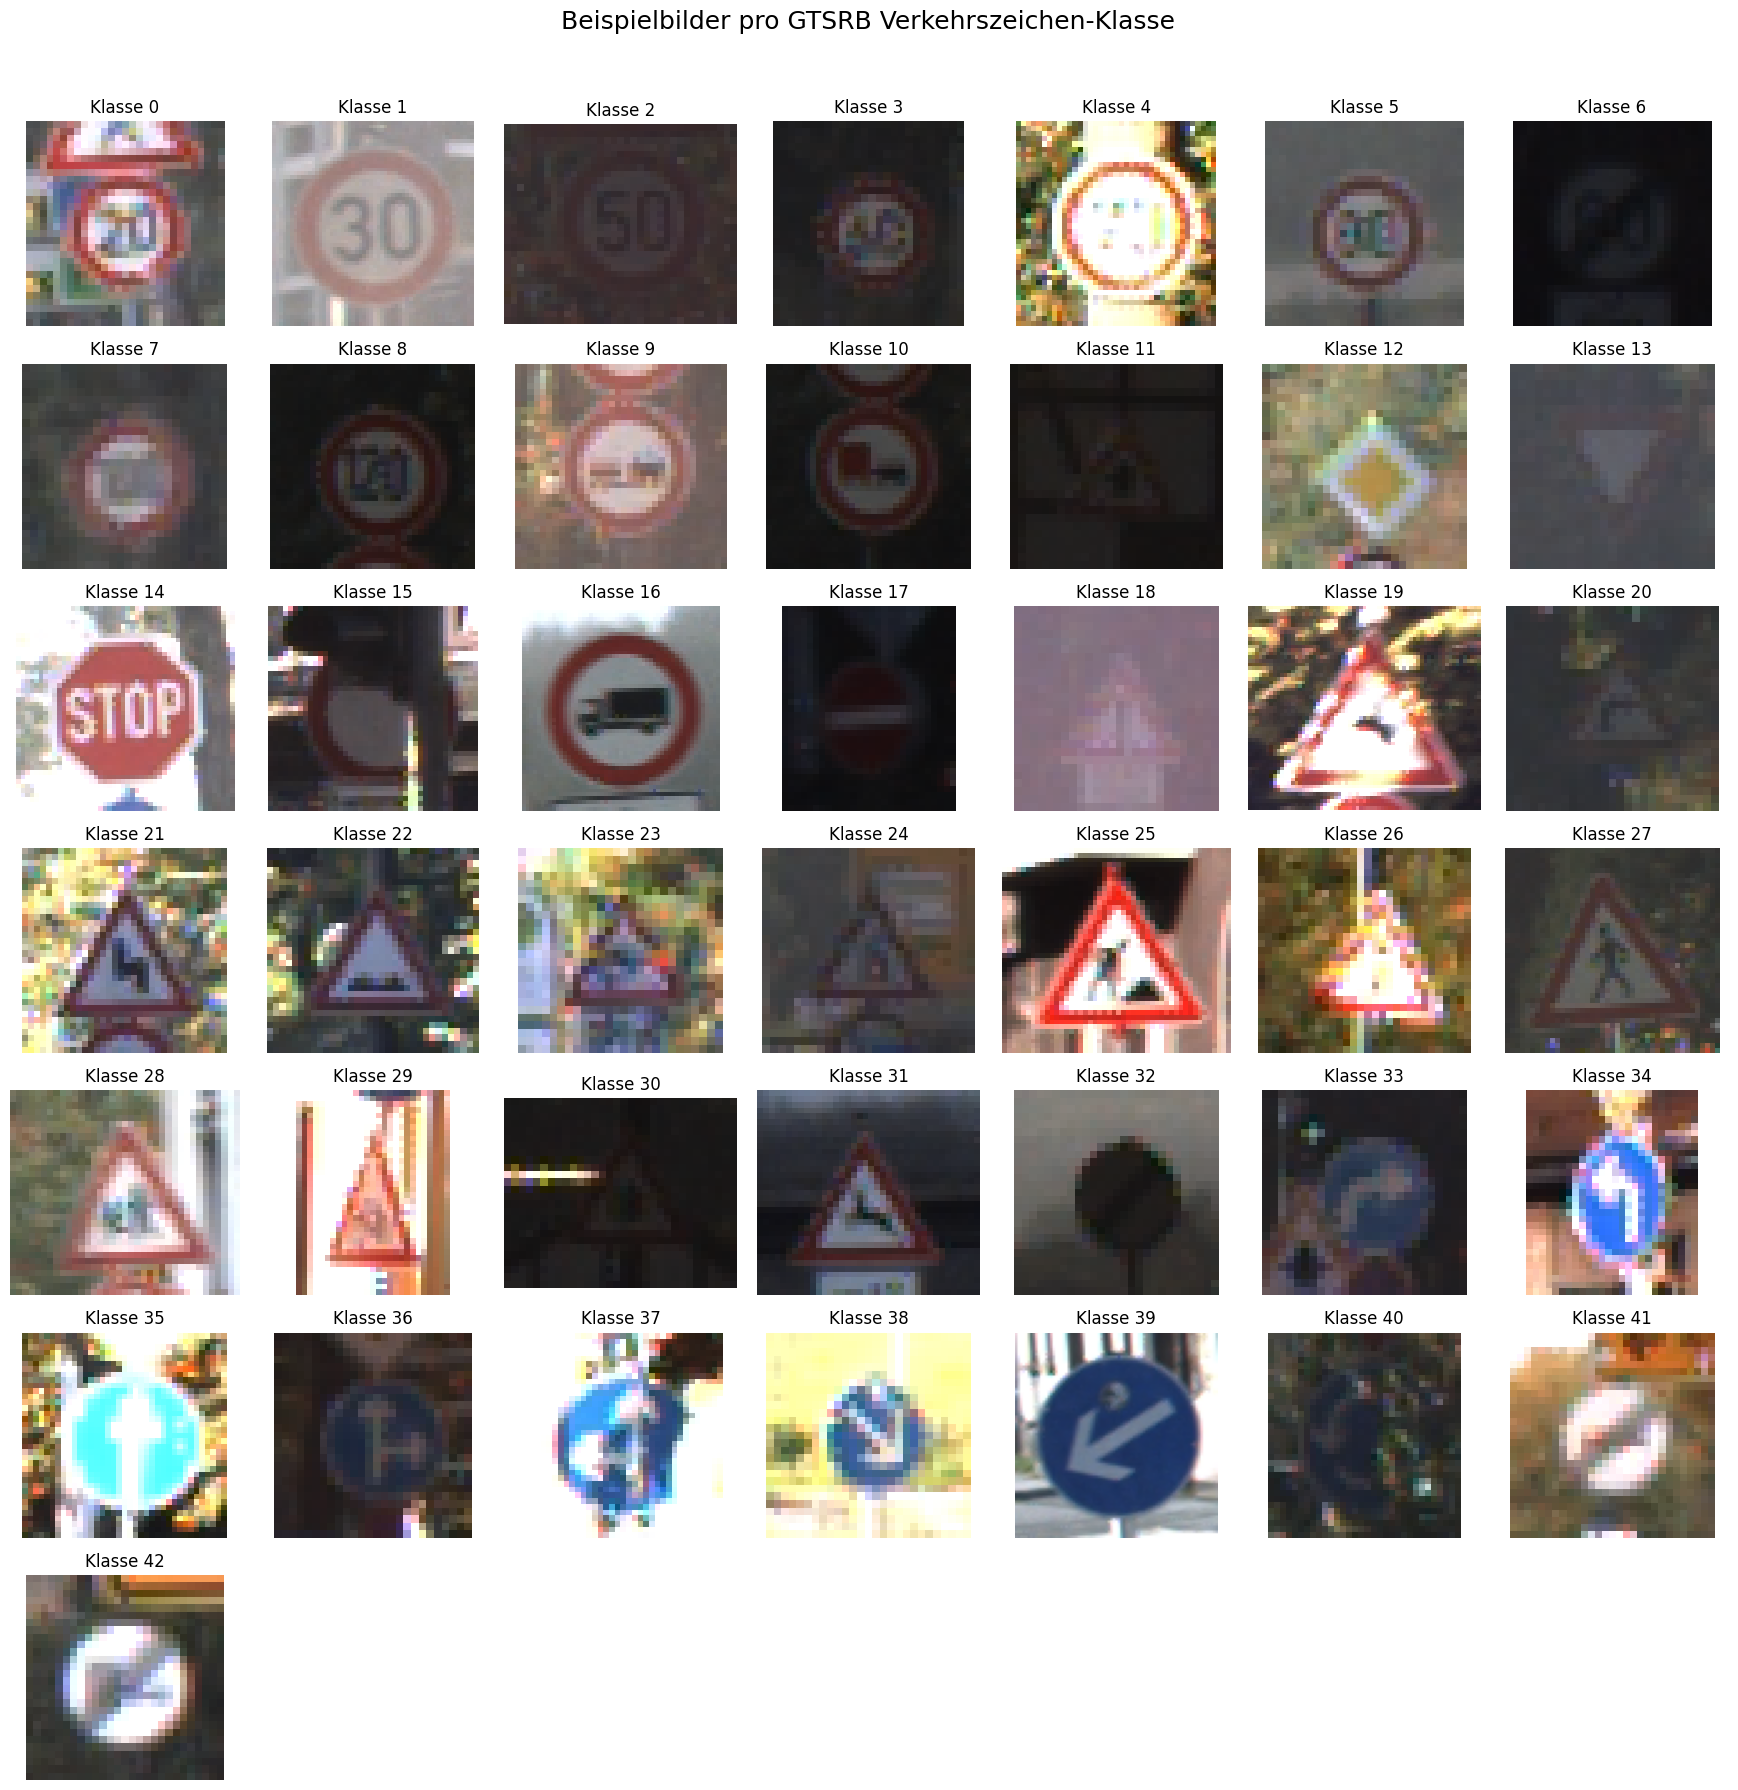

In [ ]:
def visualize_gtsrb_classes_cv2(data_dir):
    """
    Lädt und zeigt ein Beispielbild für jede der 43 GTSRB-Verkehrszeichenklassen an.

    Args:
        data_dir (str): 'data_dir/Final_Training/Images/'
    """
    train_images_base_dir = os.path.join(data_dir, 'Final_Training', 'Images')
    num_classes = 43 

   
    rows = 7
    cols = 7
   
    _, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten() 

    print(f"Lade und zeige ein Bild pro Klasse (insgesamt {num_classes} Klassen) an (mit OpenCV)...")

    # Iteriere durch jede Klasse von 0 bis 42
    for class_id in range(num_classes):
        class_id_str = f"{class_id:05d}"
        class_dir = os.path.join(train_images_base_dir, class_id_str)
        csv_path = os.path.join(class_dir, f'GT-{class_id_str}.csv')

        ax = axes[class_id] 

        if not os.path.exists(csv_path):
            print(f"Warnung: CSV für Klasse {class_id_str} nicht gefunden unter {csv_path}. Überspringe.")
            ax.set_title(f"Klasse {class_id}\n(Keine Daten)", fontsize=10)
            ax.axis('off') 
            continue

        try:
            # Laden der CSV-Datei
            df = pd.read_csv(csv_path, sep=';')

            if df.empty:
                print(f"Warnung: CSV für Klasse {class_id_str} ist leer. Überspringe.")
                ax.set_title(f"Klasse {class_id}\n(Leere CSV)", fontsize=10)
                ax.axis('off')
                continue

            image_filename = df['Filename'].iloc[0]
            image_path = os.path.join(class_dir, image_filename)

            # Überprüfen, ob die Bilddatei existiert
            if not os.path.exists(image_path):
                print(f"Warnung: Bild '{image_filename}' für Klasse {class_id_str} nicht gefunden unter {image_path}. Überspringe.")
                ax.set_title(f"Klasse {class_id}\n(Bild fehlt)", fontsize=10)
                ax.axis('off')
                continue

            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            ax.imshow(img)
            ax.set_title(f"Klasse {class_id}", fontsize=12)
            ax.axis('off')

        except Exception as e:
            print(f"Fehler beim Laden/Anzeigen von Klasse {class_id_str}: {e}. Überspringe.")
            ax.set_title(f"Klasse {class_id}\n(Fehler)", fontsize=10)
            ax.axis('off')
            continue
    for i in range(num_classes, rows * cols):
        axes[i].axis('off')

    plt.suptitle("Beispielbilder pro GTSRB Verkehrszeichen-Klasse", fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


data_directory = 'data/GTSRB'
visualize_gtsrb_classes_cv2(data_directory)


### loading images separately

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

def load_gtsrb_data(data_dir):
    """
    Lädt den GTSRB-Datensatz aus dem angegebenen Verzeichnis.

    Args:
        data_dir (str): Pfad zum GTSRB-Verzeichnis (z.B. 'data/GTSRB').

    Returns:
        tuple: Ein Tupel, das vier NumPy-Arrays enthält:
            - train_images (np.array): Ein Array von Training-Bildern (als NumPy-Arrays).
            - train_labels (np.array): Ein Array der entsprechenden Train-Labels.
            - test_images (np.array): Ein Array von Test-Bildern (als NumPy-Arrays).
            - test_labels (np.array): Ein Array der entsprechenden Test-Labels.
    """
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    # --- Trainingsdaten laden ---
    train_images_dir = os.path.join(data_dir, 'Final_Training', 'Images')

    # Gehe durch jeden Klassenordner (00000, 00001, ...)
    for class_id_str in sorted(os.listdir(train_images_dir)):
        class_path = os.path.join(train_images_dir, class_id_str)
        
        if not os.path.isdir(class_path):
            continue 

        csv_path = os.path.join(class_path, f'GT-{class_id_str}.csv')
        
        try:
            # Laden der CSV-Datei 
            df = pd.read_csv(csv_path, sep=';')
        except FileNotFoundError:
            print(f"Warnung: CSV-Datei '{csv_path}' nicht gefunden. Klasse {class_id_str} wird übersprungen.")
            continue
        except pd.errors.EmptyDataError:
            print(f"Warnung: CSV-Datei '{csv_path}' ist leer. Klasse {class_id_str} wird übersprungen.")
            continue
        except Exception as e:
            print(f"Fehler beim Laden der CSV-Datei '{csv_path}': {e}. Klasse {class_id_str} wird übersprungen.")
            continue

        for _, row in df.iterrows():
            img_filename = row['Filename']
            img_path = os.path.join(class_path, img_filename)
            
            try:
                # Bild mit OpenCV laden
                img = cv2.imread(img_path)
                
                if img is not None:
                    # ROI Zuschnitt
                    train_images.append(img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']])
                    train_labels.append(row['ClassId'])
                else:
                    print(f"Warnung: Bild konnte nicht gelesen werden (img is None): {img_path}")
            except Exception as e:
                print(f"Fehler beim Lesen des Bildes '{img_path}': {e}")

    # --- Testdaten laden ---
    
    # Pfad zum Hauptordner der Testbilder
    test_images_base_dir = os.path.join(data_dir, 'Final_Test', 'Images')
    # Pfad zur zentralen CSV-Datei für die Testdaten
    test_csv_path = os.path.join(test_images_base_dir, 'GT-final_test.csv')

    try:
        # Laden der zentrale CSV-Datei für die Testdaten
        test_df = pd.read_csv(test_csv_path, sep=';')
    except FileNotFoundError:
        print(f"Warnung: Test-CSV '{test_csv_path}' nicht gefunden. Testdaten werden nicht geladen.")
        # Falls keine Test-CSV gefunden wird, die bisher geladenen Trainingsdaten zurückgeben
        return np.array(train_images, dtype=object), np.array(train_labels)
    except Exception as e:
        print(f"Fehler beim Laden der Test-CSV '{test_csv_path}': {e}. Testdaten werden nicht geladen.")
        return np.array(train_images, dtype=object), np.array(train_labels)

    for _, row in test_df.iterrows():
        img_filename = row['Filename']
        img_path = os.path.join(test_images_base_dir, img_filename)
        
        try:
            img = cv2.imread(img_path)
            if img is not None:
                # ROI Zuschnitt
                test_images.append(img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']])
                test_labels.append(row['ClassId'])
            else:
                print(f"Warnung: Testbild konnte nicht gelesen werden (img is None): {img_path}")
        except Exception as e:
            print(f"Fehler beim Lesen oder Zuschneiden des Testbildes '{img_path}': {e}")
            
    # Konvertiere die Listen in NumPy-Arrays
    # dtype=object ist nötig, da die zugeschnittenen Bilder immer noch unterschiedliche Größen haben können.
    return np.array(train_images, dtype=object), np.array(train_labels), np.array(test_images, dtype=object), np.array(test_labels)


data_directory = 'data/GTSRB' 

print(f"Starte Ladevorgang aus: {data_directory}")
train_images, train_labels, test_images, test_labels = load_gtsrb_data(data_directory)

print(f"\nErfolgreich {len(train_images)} Trainings-Bilder und {len(train_labels)} Trainings-Labels geladen, {len(test_images)} Test-Bilder und {len(test_labels)} Test-Labels geladen.")

# jeweils die Form des ersten Bildes prüfen
if len(train_images) > 0:
    print("Trainings-Bilder:")
    print(f"Form des ersten geladenen Bildes: {train_images[0].shape}")
    print(f"Label des ersten geladenen Bildes: {train_labels[0]}")
    print(f"Typ von 'images': {type(train_images)}, Typ der Elemente: {type(train_images[0])}")
    print(f"Typ von 'labels': {type(train_labels)}, Typ der Elemente: {type(train_labels[0])}")
    print("----------------------------------------------------------------------------------")
    
if len(test_images) > 0:
    print("Testbilder:")
    print(f"Form des ersten geladenen Bildes: {test_images[0].shape}")
    print(f"Label des ersten geladenen Bildes: {test_labels[0]}")
    print(f"Typ von 'images': {type(test_images)}, Typ der Elemente: {type(test_images[0])}")
    print(f"Typ von 'labels': {type(test_labels)}, Typ der Elemente: {type(test_labels[0])}")


Starte Ladevorgang aus: data/GTSRB

Erfolgreich 39209 Trainings-Bilder und 39209 Trainings-Labels geladen, 12630 Test-Bilder und 12630 Test-Labels geladen.
Trainings-Bilder:
Form des ersten geladenen Bildes: (19, 19, 3)
Label des ersten geladenen Bildes: 0
Typ von 'images': <class 'numpy.ndarray'>, Typ der Elemente: <class 'numpy.ndarray'>
Typ von 'labels': <class 'numpy.ndarray'>, Typ der Elemente: <class 'numpy.int64'>
----------------------------------------------------------------------------------
Testbilder:
Form des ersten geladenen Bildes: (44, 42, 3)
Label des ersten geladenen Bildes: 16
Typ von 'images': <class 'numpy.ndarray'>, Typ der Elemente: <class 'numpy.ndarray'>
Typ von 'labels': <class 'numpy.ndarray'>, Typ der Elemente: <class 'numpy.int64'>


# Schritt 3: EDA

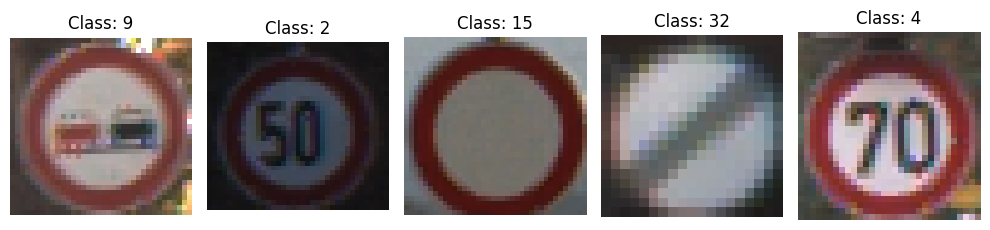

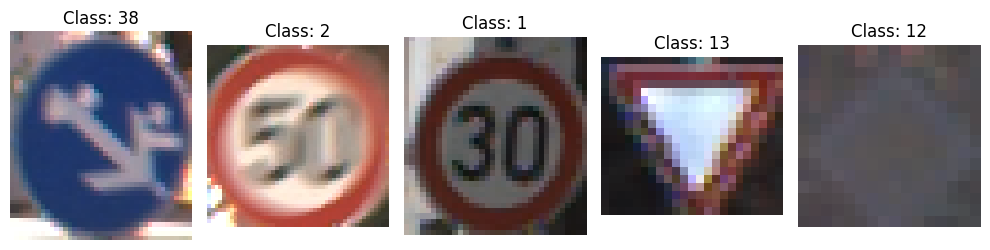

In [73]:
import matplotlib.pyplot as plt
import random
import cv2 

plt.figure(figsize=(10, 4))
num_samples_to_show = 5
for i in range(num_samples_to_show):
    idx = random.randint(0, len(train_images) - 1) 

    plt.subplot(1, num_samples_to_show, i + 1)
    # OpenCV lädt Bilder als BGR, Matplotlib erwartet RGB.
    plt.imshow(cv2.cvtColor(train_images[idx], cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {train_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
num_samples_to_show = 5
for i in range(num_samples_to_show):
    idx = random.randint(0, len(test_images) - 1) 

    plt.subplot(1, num_samples_to_show, i + 1)
    # OpenCV lädt Bilder als BGR, Matplotlib erwartet RGB.
    plt.imshow(cv2.cvtColor(test_images[idx], cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {test_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_19629/2165101850.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette='viridis')


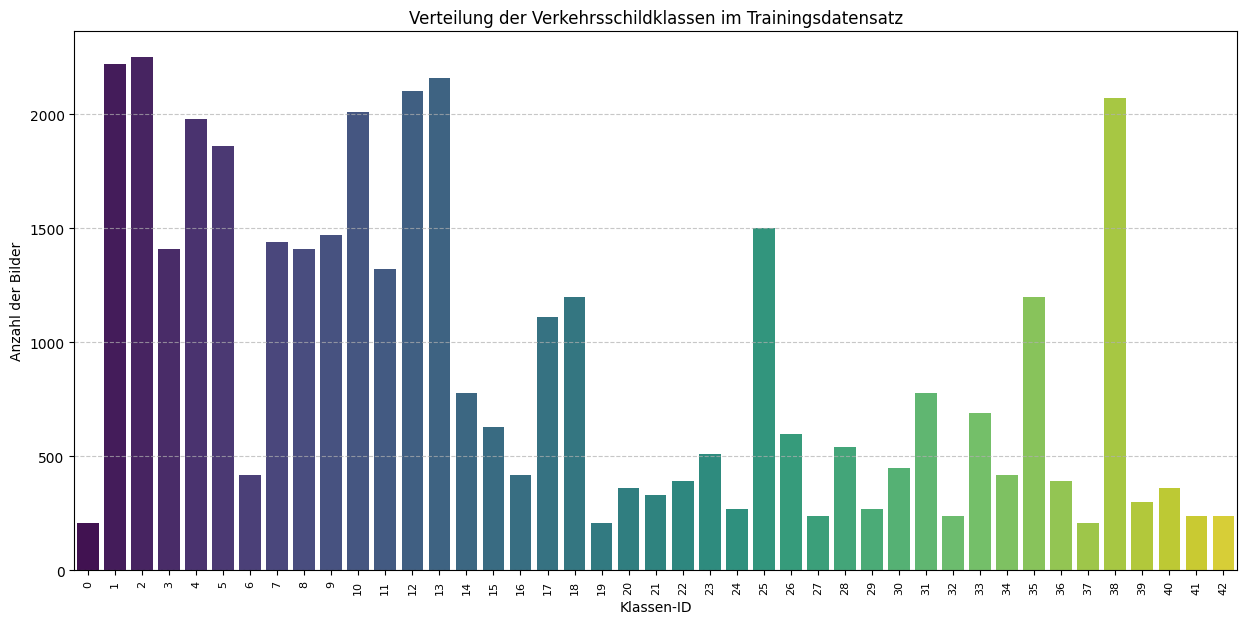

Klasse 0: 210 Bilder
Klasse 1: 2220 Bilder
Klasse 2: 2250 Bilder
Klasse 3: 1410 Bilder
Klasse 4: 1980 Bilder
Klasse 5: 1860 Bilder
Klasse 6: 420 Bilder
Klasse 7: 1440 Bilder
Klasse 8: 1410 Bilder
Klasse 9: 1470 Bilder
Klasse 10: 2010 Bilder
Klasse 11: 1320 Bilder
Klasse 12: 2100 Bilder
Klasse 13: 2160 Bilder
Klasse 14: 780 Bilder
Klasse 15: 630 Bilder
Klasse 16: 420 Bilder
Klasse 17: 1110 Bilder
Klasse 18: 1200 Bilder
Klasse 19: 210 Bilder
Klasse 20: 360 Bilder
Klasse 21: 330 Bilder
Klasse 22: 390 Bilder
Klasse 23: 510 Bilder
Klasse 24: 270 Bilder
Klasse 25: 1500 Bilder
Klasse 26: 600 Bilder
Klasse 27: 240 Bilder
Klasse 28: 540 Bilder
Klasse 29: 270 Bilder
Klasse 30: 450 Bilder
Klasse 31: 780 Bilder
Klasse 32: 240 Bilder
Klasse 33: 689 Bilder
Klasse 34: 420 Bilder
Klasse 35: 1200 Bilder
Klasse 36: 390 Bilder
Klasse 37: 210 Bilder
Klasse 38: 2070 Bilder
Klasse 39: 300 Bilder
Klasse 40: 360 Bilder
Klasse 41: 240 Bilder
Klasse 42: 240 Bilder


/tmp/ipykernel_19629/2165101850.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels, palette='viridis')


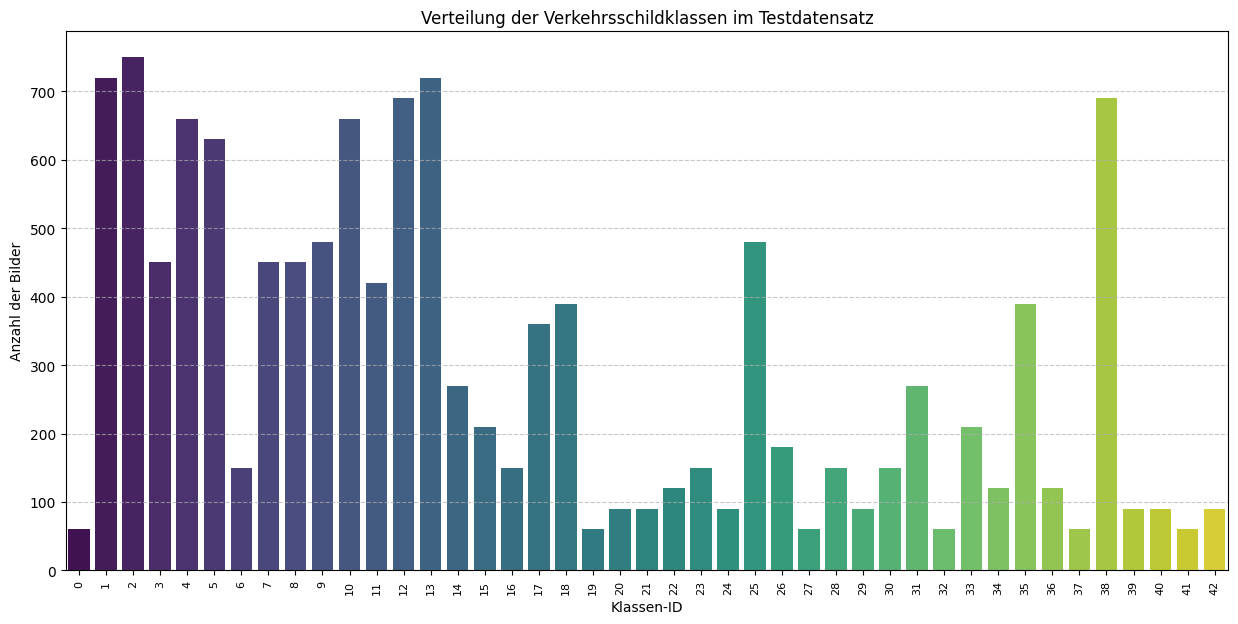

Klasse 0: 60 Bilder
Klasse 1: 720 Bilder
Klasse 2: 750 Bilder
Klasse 3: 450 Bilder
Klasse 4: 660 Bilder
Klasse 5: 630 Bilder
Klasse 6: 150 Bilder
Klasse 7: 450 Bilder
Klasse 8: 450 Bilder
Klasse 9: 480 Bilder
Klasse 10: 660 Bilder
Klasse 11: 420 Bilder
Klasse 12: 690 Bilder
Klasse 13: 720 Bilder
Klasse 14: 270 Bilder
Klasse 15: 210 Bilder
Klasse 16: 150 Bilder
Klasse 17: 360 Bilder
Klasse 18: 390 Bilder
Klasse 19: 60 Bilder
Klasse 20: 90 Bilder
Klasse 21: 90 Bilder
Klasse 22: 120 Bilder
Klasse 23: 150 Bilder
Klasse 24: 90 Bilder
Klasse 25: 480 Bilder
Klasse 26: 180 Bilder
Klasse 27: 60 Bilder
Klasse 28: 150 Bilder
Klasse 29: 90 Bilder
Klasse 30: 150 Bilder
Klasse 31: 270 Bilder
Klasse 32: 60 Bilder
Klasse 33: 210 Bilder
Klasse 34: 120 Bilder
Klasse 35: 390 Bilder
Klasse 36: 120 Bilder
Klasse 37: 60 Bilder
Klasse 38: 690 Bilder
Klasse 39: 90 Bilder
Klasse 40: 90 Bilder
Klasse 41: 60 Bilder
Klasse 42: 90 Bilder


In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.countplot(x=train_labels, palette='viridis')
plt.title('Verteilung der Verkehrsschildklassen im Trainingsdatensatz')
plt.xlabel('Klassen-ID')
plt.ylabel('Anzahl der Bilder')
plt.xticks(rotation=90, fontsize=8) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Anzahl der Train-Bilder pro Klasse in Zahlen
unique_labels, counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Klasse {label}: {count} Bilder")
    
plt.figure(figsize=(15, 7))
sns.countplot(x=test_labels, palette='viridis')
plt.title('Verteilung der Verkehrsschildklassen im Testdatensatz')
plt.xlabel('Klassen-ID')
plt.ylabel('Anzahl der Bilder')
plt.xticks(rotation=90, fontsize=8) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Anzahl der Test-Bilder pro Klasse in Zahlen
unique_labels, counts = np.unique(test_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Klasse {label}: {count} Bilder")

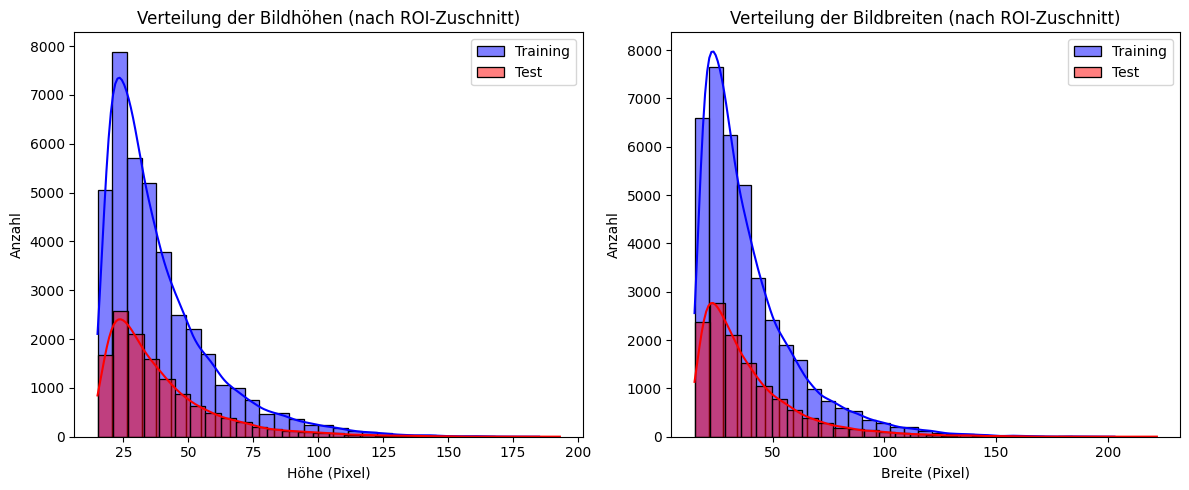

Trainingsdaten |  Minimale Bildhöhe: 15, Maximale Bildhöhe: 185
Trainingsdaten | Minimale Bildbreite: 15, Maximale Bildbreite: 203
Testdaten | Minimale Bildhöhe: 15, Maximale Bildhöhe: 185
Testdaten | Minimale Bildbreite: 15, Maximale Bildbreite: 203


In [ ]:
image_heights_train = [img.shape[0] for img in train_images]
image_widths_train = [img.shape[1] for img in train_images]

image_heights_test = [img.shape[0] for img in test_images]
image_widths_test = [img.shape[1] for img in test_images]

plt.figure(figsize=(12, 5))

# Plot für Bildhöhen
ax1 = plt.subplot(1, 2, 1)
sns.histplot(image_heights_train, bins=30, kde=True, color='blue', label='Training', ax=ax1)
sns.histplot(image_heights_test, bins=30, kde=True, color='red', label='Test', ax=ax1)
plt.title('Verteilung der Bildhöhen (nach ROI-Zuschnitt)')
plt.xlabel('Höhe (Pixel)')
plt.ylabel('Anzahl')
plt.legend()

# Plot für Bildbreiten
ax2 = plt.subplot(1, 2, 2)
sns.histplot(image_widths_train, bins=30, kde=True, color='blue', label='Training', ax=ax2)
sns.histplot(image_widths_test, bins=30, kde=True, color='red', label='Test', ax=ax2)
plt.title('Verteilung der Bildbreiten (nach ROI-Zuschnitt)')
plt.xlabel('Breite (Pixel)')
plt.ylabel('Anzahl')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Trainingsdaten |  Minimale Bildhöhe: {np.min(image_heights_train)}, Maximale Bildhöhe: {np.max(image_heights_train)}")
print(f"Trainingsdaten | Minimale Bildbreite: {np.min(image_widths_train)}, Maximale Bildbreite: {np.max(image_widths_train)}")

print(f"Testdaten | Minimale Bildhöhe: {np.min(image_heights_train)}, Maximale Bildhöhe: {np.max(image_heights_train)}")
print(f"Testdaten | Minimale Bildbreite: {np.min(image_widths_train)}, Maximale Bildbreite: {np.max(image_widths_train)}")

# Schritt 4: Feature Engineering

In [ ]:

# --- Skalierung auf einheitliche Größe, Farbkonvertierung und Normalisierung ---
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3 #(RGB)

processed_train_images = []
for img in train_images:
    # Sicherstellen, dass das Bild 3 Kanäle hat und dann BGR zu RGB konvertieren
    #edge cases
    if len(img.shape) == 2: 
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 
    elif img.shape[2] == 4: 
        img_bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR) 
    else: 
        img_bgr = img

    resized_img = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))
    resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) # <<< BGR zu RGB Konvertierung 
    processed_train_images.append(resized_img_rgb) 

X_train = np.array(processed_train_images) 

# Normalisierung der Pixelwerte auf [0, 1]
X_train = X_train / 255.0

print("Trainings-Bilder:")
print(f"Form des verarbeiteten und normalisierten Bild-Arrays (X): {X_train.shape}")
print(f"Minimale Pixelwert nach Normalisierung: {np.min(X_train)}")
print(f"Maximale Pixelwert nach Normalisierung: {np.max(X_train)}")

processed_test_images = []
for img in test_images:
    #edge cases
    if len(img.shape) == 2: 
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 
    elif img.shape[2] == 4: 
        img_bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR) 
    else: 
        img_bgr = img

    resized_img = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))
    resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) 
    processed_test_images.append(resized_img_rgb) 

X_test = np.array(processed_test_images) 

# Normalisierung der Pixelwerte auf [0, 1]
X_test = X_test / 255.0

print("Test-Bilder:")
print(f"Form des verarbeiteten und normalisierten Bild-Arrays (X): {X_test.shape}")
print(f"Minimale Pixelwert nach Normalisierung: {np.min(X_test)}")
print(f"Maximale Pixelwert nach Normalisierung: {np.max(X_test)}")



Trainings-Bilder:
Form des verarbeiteten und normalisierten Bild-Arrays (X): (39209, 32, 32, 3)
Minimale Pixelwert nach Normalisierung: 0
Maximale Pixelwert nach Normalisierung: 255
Test-Bilder:
Form des verarbeiteten und normalisierten Bild-Arrays (X): (12630, 32, 32, 3)
Minimale Pixelwert nach Normalisierung: 0
Maximale Pixelwert nach Normalisierung: 255


### Train-Validate-Test Split für pre-split Set

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(np.concatenate((train_labels, test_labels))))
print(f"Ermittelte Anzahl der Klassen: {num_classes}")

X_train_final, X_val_final, y_train_int, y_val_int = train_test_split(
    X_train,              
    train_labels,         
    test_size=0.176,      
    random_state=42,
    stratify=train_labels 
)

#Label-Kodierung One-Hot-Encoding

y_train_final = to_categorical(y_train_int, num_classes=num_classes)
y_val_final = to_categorical(y_val_int, num_classes=num_classes)
y_test_final = to_categorical(test_labels, num_classes=num_classes)

# --- Ergebnisse ausgeben ---
print("\nFinal vorbereitete Daten-Shapes:")
print(f"Trainingsdaten: X_train_final.shape={X_train_final.shape}, y_train_final.shape={y_train_final.shape}")
print(f"Validierungsdaten: X_val_final.shape={X_val_final.shape}, y_val_final.shape={y_val_final.shape}")
print(f"Testdaten: X_test.shape={X_test.shape}, y_test_final.shape={y_test_final.shape}")
print(f"Anzahl der Klassen (für One-Hot-Kodierung verwendet): {num_classes}")



Ermittelte Anzahl der Klassen: 43

Final vorbereitete Daten-Shapes:
Trainingsdaten: X_train_final.shape=(32308, 32, 32, 3), y_train_final.shape=(32308, 43)
Validierungsdaten: X_val_final.shape=(6901, 32, 32, 3), y_val_final.shape=(6901, 43)
Testdaten: X_test.shape=(12630, 32, 32, 3), y_test_final.shape=(12630, 43)
Anzahl der Klassen (für One-Hot-Kodierung verwendet): 43


Starte Ladevorgang aus: data/GTSRB

Erfolgreich 51839 Bilder und 51839 Labels geladen.
Form des ersten geladenen Bildes: (19, 19, 3)
Label des ersten geladenen Bildes: 0


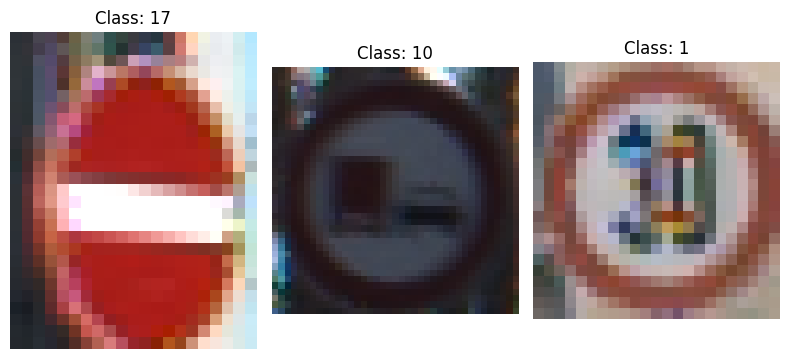

Form des verarbeiteten Bild-Arrays: (51839, 32, 32, 3)
Minimale Pixelwert nach Normalisierung: 0
Maximale Pixelwert nach Normalisierung: 255
Original Label des ersten Bildes: 0
One-Hot kodiertes Label des ersten Bildes: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Form der kodierten Labels: (51839, 43)
X_train.shape: (36307, 32, 32, 3), y_train.shape: (36307, 43)
X_val.shape: (7756, 32, 32, 3), y_val.shape: (7756, 43)
X_test.shape: (7776, 32, 32, 3), y_test.shape: (7776, 43)

Daten vorbereitet:
Trainingsdaten: X_train.shape=(36307, 32, 32, 3), y_train.shape=(36307, 43)
Validierungsdaten: X_val.shape=(7756, 32, 32, 3), y_val.shape=(7756, 43)
Testdaten: X_test.shape=(7776, 32, 32, 3), y_test.shape=(7776, 43)
Anzahl der Klassen: 43


In [ ]:
# Code, um Datenset in ein einzelnes Array zu laden

import os
import cv2
import pandas as pd
import numpy as np

def load_gtsrb_data(data_dir):
    """
    Lädt den GTSRB-Datensatz aus dem angegebenen Verzeichnis.

    Args:
        data_dir (str): Pfad zum GTSRB-Verzeichnis ( 'data/GTSRB').

    Returns:
        tuple: Ein Tupel, das zwei NumPy-Arrays enthält:
            - images (np.array): Ein Array von Bildern (als NumPy-Arrays).
            - labels (np.array): Ein Array der entsprechenden Labels.
    """
    all_images = []
    all_labels = []

    # --- Trainingsdaten laden ---
    train_images_base_dir = os.path.join(data_dir, 'Final_Training', 'Images')

    for class_id_str in sorted(os.listdir(train_images_base_dir)):
        class_path = os.path.join(train_images_base_dir, class_id_str)
        
        if not os.path.isdir(class_path):
            continue 

        csv_path = os.path.join(class_path, f'GT-{class_id_str}.csv')
        
        try:
            df = pd.read_csv(csv_path, sep=';')
        except FileNotFoundError:
            print(f"Warnung: Trainings-CSV '{csv_path}' nicht gefunden. Klasse {class_id_str} wird übersprungen.")
            continue
        except pd.errors.EmptyDataError:
            print(f"Warnung: Trainings-CSV '{csv_path}' ist leer. Klasse {class_id_str} wird übersprungen.")
            continue
        except Exception as e:
            print(f"Fehler beim Laden der Trainings-CSV '{csv_path}': {e}. Klasse {class_id_str} wird übersprungen.")
            continue

        for _, row in df.iterrows():
            img_filename = row['Filename']
            img_path = os.path.join(class_path, img_filename)
            
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    all_images.append(img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']])
                    all_labels.append(row['ClassId'])
                else:
                    print(f"Warnung: Trainingsbild konnte nicht gelesen werden (img is None): {img_path}")
            except Exception as e:
                print(f"Fehler beim Lesen oder Zuschneiden des Trainingsbildes '{img_path}': {e}")

    # --- Testdaten laden ---
    test_images_base_dir = os.path.join(data_dir, 'Final_Test', 'Images')
    test_csv_path = os.path.join(test_images_base_dir, 'GT-final_test.csv')

    try:
        test_df = pd.read_csv(test_csv_path, sep=';')
    except FileNotFoundError:
        print(f"Warnung: Test-CSV '{test_csv_path}' nicht gefunden. Testdaten werden nicht geladen.")
        return np.array(all_images, dtype=object), np.array(all_labels)
    except Exception as e:
        print(f"Fehler beim Laden der Test-CSV '{test_csv_path}': {e}. Testdaten werden nicht geladen.")
        return np.array(all_images, dtype=object), np.array(all_labels)

    for _, row in test_df.iterrows():
        img_filename = row['Filename']
        img_path = os.path.join(test_images_base_dir, img_filename)
        
        try:
            img = cv2.imread(img_path)
            if img is not None:
                all_images.append(img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']])
                all_labels.append(row['ClassId'])
            else:
                print(f"Warnung: Testbild konnte nicht gelesen werden (img is None): {img_path}")
        except Exception as e:
            print(f"Fehler beim Lesen oder Zuschneiden des Testbildes '{img_path}': {e}")
            
    return np.array(all_images, dtype=object), np.array(all_labels)


data_directory = 'data/GTSRB' 

print(f"Starte Ladevorgang aus: {data_directory}")
images, labels = load_gtsrb_data(data_directory)

print(f"\nErfolgreich {len(images)} Bilder und {len(labels)} Labels geladen.")

if len(images) > 0:
    print(f"Form des ersten geladenen Bildes: {images[0].shape}")
    print(f"Label des ersten geladenen Bildes: {labels[0]}")
    
    import matplotlib.pyplot as plt
    import random

    plt.figure(figsize=(8, 8))
    # Zeige 3 zufällige Bilder aus den geladenen Daten
    for i in range(3):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
        plt.title(f"Class: {labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    
IMG_HEIGHT = 32 
IMG_WIDTH = 32  

processed_images = []
for img in images:
    resized_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    processed_images.append(resized_img)

images = np.array(processed_images) 
print(f"Form des verarbeiteten Bild-Arrays: {images.shape}")

images = images / 255.0 
print(f"Minimale Pixelwert nach Normalisierung: {np.min(images)}")
print(f"Maximale Pixelwert nach Normalisierung: {np.max(images)}")


from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(labels)) 
labels_encoded = to_categorical(labels, num_classes=num_classes)

print(f"Original Label des ersten Bildes: {labels[0]}")
print(f"One-Hot kodiertes Label des ersten Bildes: {labels_encoded[0]}")
print(f"Form der kodierten Labels: {labels_encoded.shape}")

from sklearn.model_selection import train_test_split

# finale Testset abtrennen
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels_encoded, test_size=0.15, random_state=42, stratify=labels
)
# Rest in Training und Validierung 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
    # 0.176 von 85% ist ungefähr 15% vom Gesamt (0.176 * 0.85 = 0.1496)
)

print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train_final = X_train
X_val_final = X_val
X_test = X_test
y_train_final = y_train
y_val_final = y_val
y_test_final = y_test

print(f"\nDaten vorbereitet:")
print(f"Trainingsdaten: X_train.shape={X_train_final.shape}, y_train.shape={y_train_final.shape}")
print(f"Validierungsdaten: X_val.shape={X_val_final.shape}, y_val.shape={y_val_final.shape}")
print(f"Testdaten: X_test.shape={X_test.shape}, y_test.shape={y_test_final.shape}")
print(f"Anzahl der Klassen: {num_classes}")


Visualisierung einiger verarbeiteter Trainings-Bilder (nach Resizing, Normalisierung und RGB-Konvertierung):


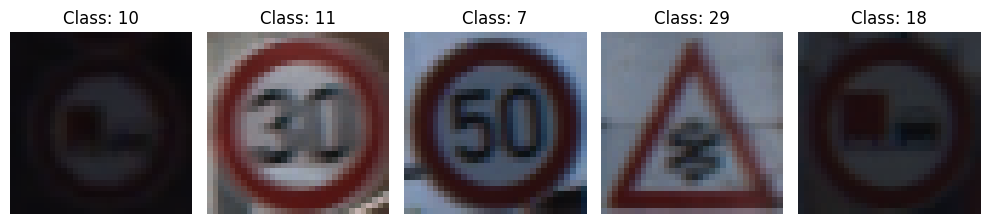

In [81]:
# --- Visualisierung einiger verarbeiteter Bilder ---
print("\nVisualisierung einiger verarbeiteter Trainings-Bilder (nach Resizing, Normalisierung und RGB-Konvertierung):")
plt.figure(figsize=(10, 4))
num_samples_to_show = 5
for i in range(num_samples_to_show):
    idx = random.randint(0, len(X_train_final) - 1)

    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(X_train[idx]) # X in RGB und normalisiert
    plt.title(f"Class: {np.argmax(y_train_final[idx])}") # One-Hot-kodierte Labels
    plt.axis('off')
plt.tight_layout()
plt.show()

# Schritt 5: Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Erste Convolutional Schicht
        Conv2D(8, (5, 5), activation='relu', input_shape=input_shape),
        AveragePooling2D((2, 2)),
        Dropout(0.25), # Dropout zur Regularisierung

        # Zweite Convolutional Schicht
        Conv2D(16, (3, 3), activation='relu'),
        AveragePooling2D((2, 2)),
        Dropout(0.25),

        # Dritte Convolutional Schicht 
        # Conv2D(128, (3, 3), activation='relu'),
        # AveragePooling2D((2, 2)),
        # Dropout(0.25),

        # Flatten der Ausgabe für die Dense Schichten
        Flatten(),

        # Dense Schichten
        Dense(128, activation='relu'),
        Dropout(0.5), 
        Dense(num_classes, activation='softmax') 
    ])

    # Modell kompilieren
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy',     
                  metrics=['accuracy'])                

    return model

# Modell erstellen
input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
model = create_cnn_model(input_shape, num_classes)

# Modellzusammenfassung anzeigen 
model.summary()



/home/mine/uni/SS25/KI_Big_Data/image_classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,179 (317.11 KB)

 Trainable params: 81,179 (317.11 KB)

 Non-trainable params: 0 (0.00 B)

## Bestes Modell (relu/MaxPooling)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5), 
        Dense(num_classes, activation='softmax') 
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy',     
                  metrics=['accuracy'])                

    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
model = create_cnn_model(input_shape, num_classes)

model.summary()



/home/mine/uni/SS25/KI_Big_Data/image_classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,979 (1.22 MB)

 Trainable params: 319,979 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

## Finales Model mit Parametern aus Random Search

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model_optimized(input_shape, num_classes):
    model = Sequential([
        # Erste Convolutional Schicht (Angepasst: filters_0, dropout_conv_0)
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.0), # Dropout auf 0.0 gesetzt

        # Zweite Convolutional Schicht (Angepasst: filters_1, dropout_conv_1)
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.0), # Dropout auf 0.0 gesetzt

        # Dritte Convolutional Schicht (Jetzt aktiviert und angepasst: filters_2, dropout_conv_2)
        Conv2D(96, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2), # Dropout für dritte Conv-Schicht

        Flatten(),

        # Erste Dense Schicht (Angepasst: units_0, dropout_dense_0)
        Dense(512, activation='relu'),
        Dropout(0.2), # Dropout angepasst

        # Zweite Dense Schicht (Neu hinzugefügt/aktiviert, angepasst: units_1, dropout_dense_1)
    
        Dense(384, activation='relu'),
        Dropout(0.3), # Dropout angepasst

        # Ausgabeschicht
        Dense(num_classes, activation='softmax')
    ])

    # Modell kompilieren (Angepasst: learning_rate)
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
model = create_cnn_model_optimized(input_shape, num_classes)

model.summary()

/home/mine/uni/SS25/KI_Big_Data/image_classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 96)       │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 43)             │        16,555 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,667 (1.75 MB)

 Trainable params: 458,667 (1.75 MB)

 Non-trainable params: 0 (0.00 B)


Starte Modelltraining...
Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.0534 - loss: 6.2972 - val_accuracy: 0.0579 - val_loss: 3.5345
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0584 - loss: 3.5150 - val_accuracy: 0.0579 - val_loss: 3.4907
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0554 - loss: 3.4893 - val_accuracy: 0.0579 - val_loss: 3.4825
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0582 - loss: 3.4872 - val_accuracy: 0.0579 - val_loss: 3.4808
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0569 - loss: 3.4820 - val_accuracy: 0.0579 - val_loss: 3.4804
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.0558 - loss: 3.4848 - val_accuracy: 0.0579 - val_loss: 3.4802
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0573 - loss: 3.4747 - val_accuracy: 0.0579 - val_loss: 3.4802
Epoch 8/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms

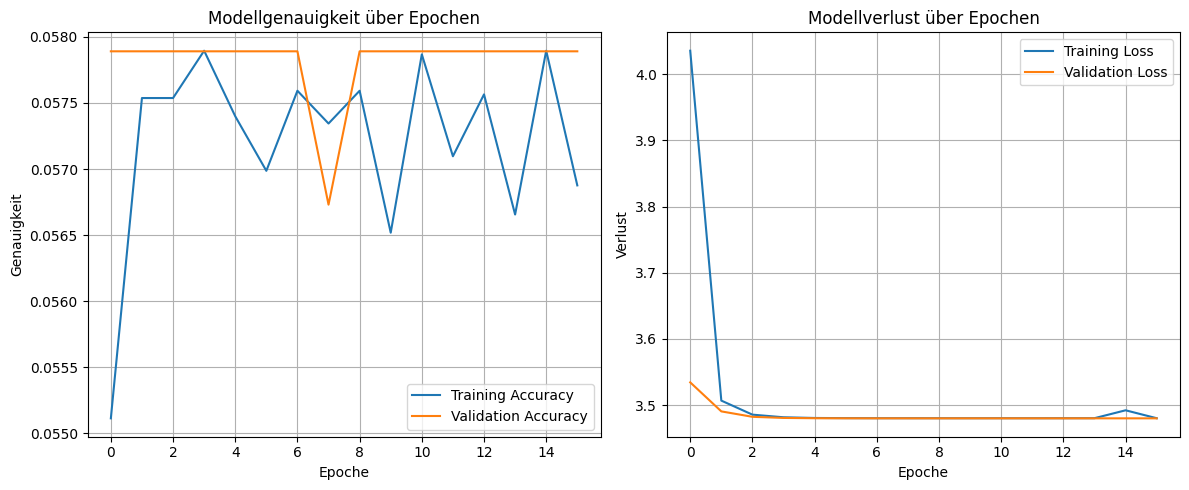

In [ ]:
# --- Modelltraining ---

print("\nStarte Modelltraining...")
# Callback für frühzeitiges Stoppen bei Overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,         # Warte 5 Epochen, wenn der Verlust sich nicht verbessert
    restore_best_weights=True # Verwende die Gewichte der besten Epoche
)

# Training durchführen
history = model.fit(
    X_train_final, y_train_final,
    epochs=50, # Anzahl der Gesamtdurchläufe
    batch_size=32, # Anzahl der Bilder pro Trainingsschritt
    validation_data=(X_val_final, y_val_final), 
    callbacks=[early_stopping], 
    verbose=1 
)

print("\nModelltraining abgeschlossen.")

# --- Trainingsverlauf visualisieren ---

plt.figure(figsize=(12, 5))

# Plot Trainings- und Validierungsgenauigkeit
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Modellgenauigkeit über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()
plt.grid(True)

# Plot Trainings- und Validierungsverlust
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Modellverlust über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# # --- Modell speichern ---
# model_save_path = 'traffic_sign_classifier_model_3_layer_32p_pre-split.keras'
# keras.saving.save_model(model, model_save_path)

# print(f"\nModell erfolgreich gespeichert als '{model_save_path}'")

In [64]:
import keras

# --- Modell speichern ---
model_save_path = 'traffic_sign_classifier_model_optimized.keras'
keras.saving.save_model(model, model_save_path)

print(f"\nModell erfolgreich gespeichert als '{model_save_path}'")


Modell erfolgreich gespeichert als 'traffic_sign_classifier_model_optimized.keras'


# Schritt 6: Modellbewertung

In [93]:
import tensorflow as tf

# --- Modell laden ---

# model_save_path = 'traffic_sign_classifier_model_pre-split.keras'
# model_save_path = 'traffic_sign_classifier_model_pre-split_avg_pool.keras'
# model_save_path = 'traffic_sign_classifier_model_pre-split_optimized_params.keras'
# model_save_path = 'traffic_sign_classifier_model_pre-split_sigmoid.keras'

model_save_path = 'traffic_sign_classifier_model_post_split_32p.keras'
# model_save_path = 'traffic_sign_classifier_model_optimized.keras'


try:
    loaded_model = tf.keras.models.load_model(model_save_path)
    print(f"\nModell '{model_save_path}' erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden des Modells: {e}. Stelle sicher, dass der Pfad korrekt ist.")
    exit() 


Modell 'traffic_sign_classifier_model_post_split_32p.keras' erfolgreich geladen.



Starte Modellbewertung auf dem Testset...
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9961 - loss: 0.0201

Test-Verlust: 0.0207
Test-Genauigkeit: 0.9961
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Klassifizierungsbericht:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       1.00      1.00      1.00       441
           2       1.00      1.00      1.00       450
           3       1.00      0.99      0.99       279
           4       1.00      1.00      1.00       396
           5       0.99      0.99      0.99       374
           6       1.00      0.99      0.99        85
           7       1.00      1.00      1.00       284
           8       1.00      1.00      1.00       279
           9       0.99      0.99      0.99       293
          10       1.00      1.00      1.00       401
          11       1.00      1.00      1.00       261
          12       1.00      1.00      1.00       419
          1

/tmp/ipykernel_19629/1112268015.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_metrics.index, y='precision', data=df_report_metrics, palette='viridis')
/tmp/ipykernel_19629/1112268015.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_metrics.index, y='recall', data=df_report_metrics, palette='magma')
/tmp/ipykernel_19629/1112268015.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_metrics.index, y='f1-score', data=df_report_metrics, palette='cividis')


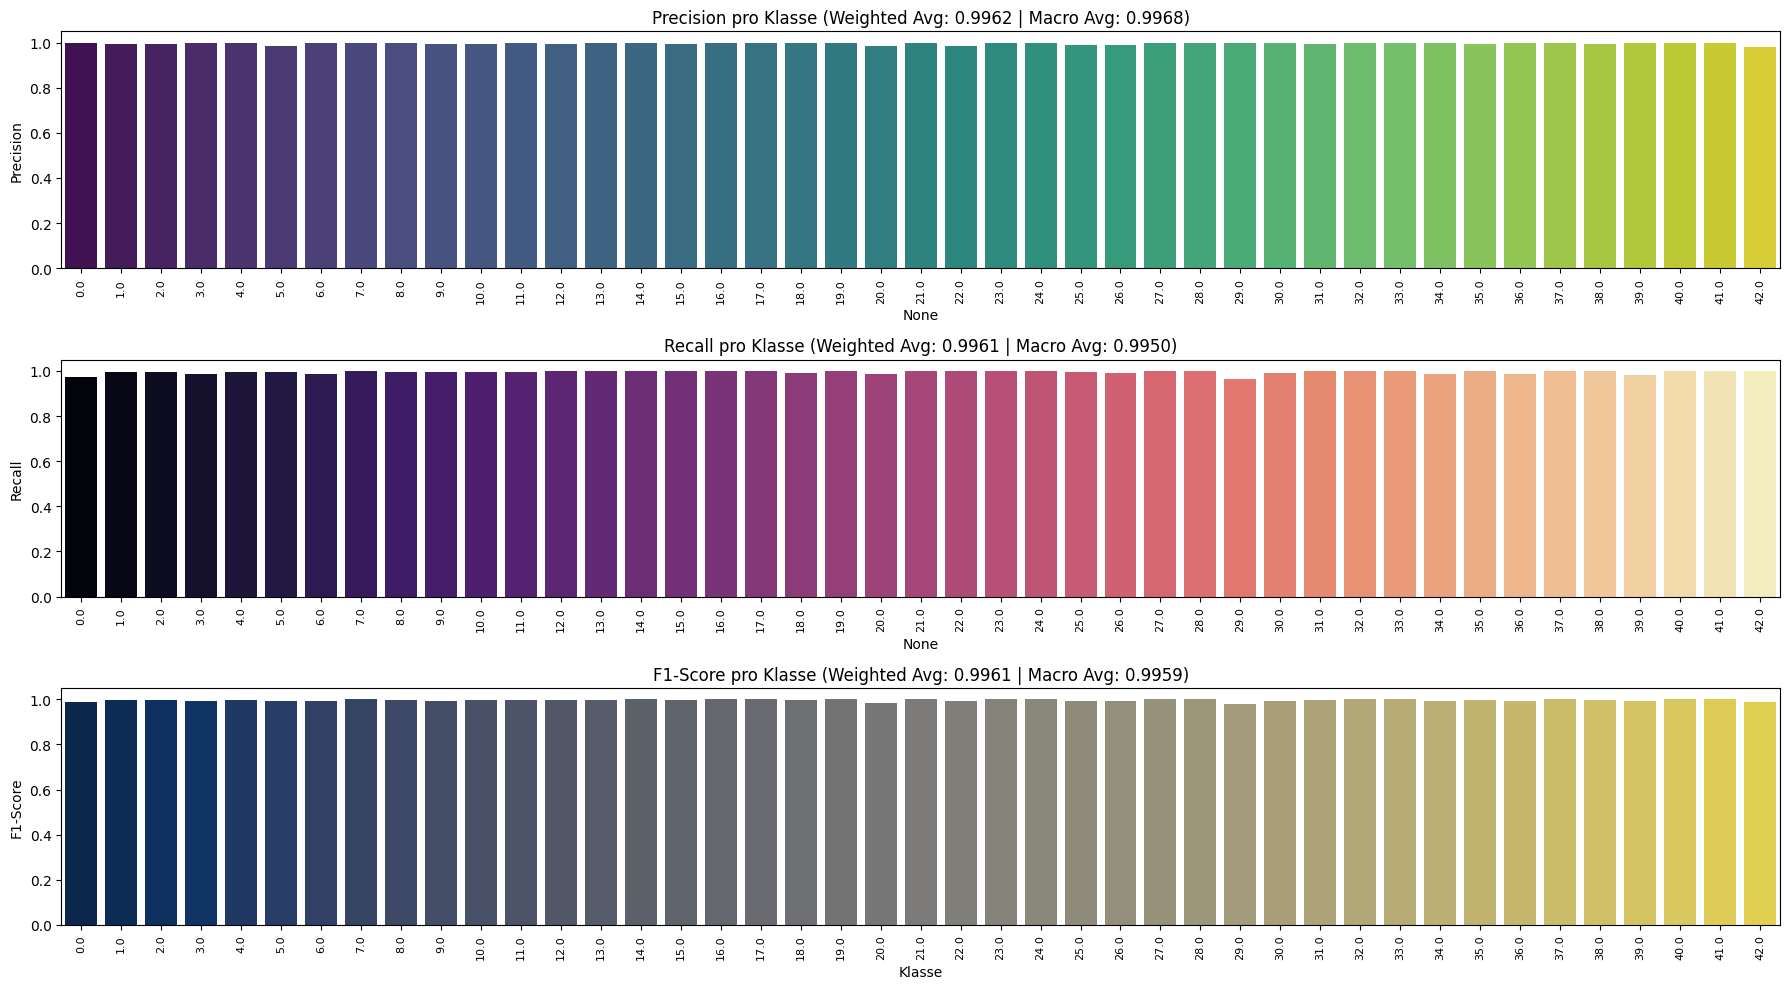


Konfusionsmatrix:


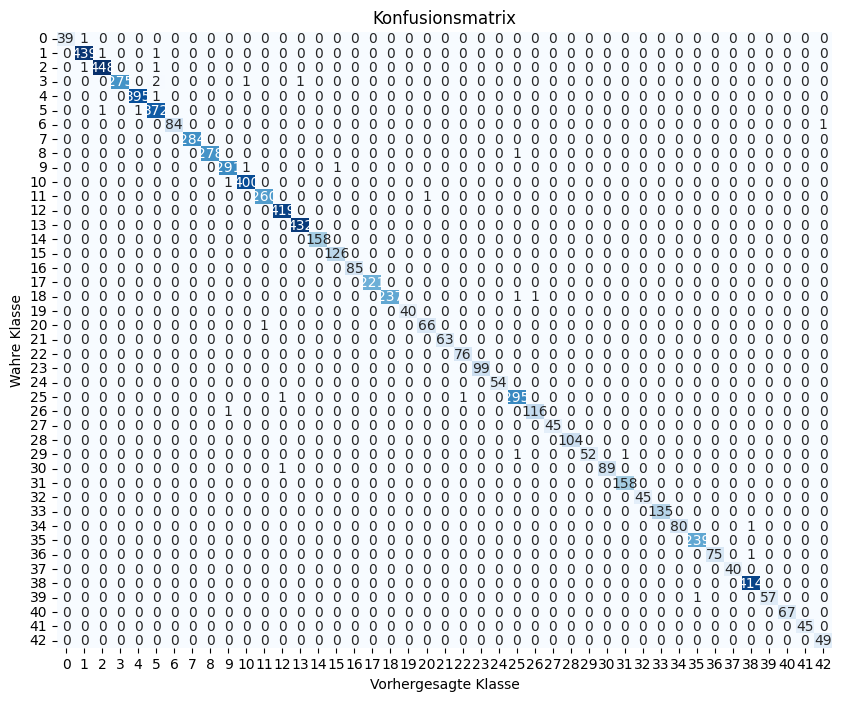

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


print("\nStarte Modellbewertung auf dem Testset...")

loss, accuracy = loaded_model.evaluate(X_test, y_test_final, verbose=1)

print(f"\nTest-Verlust: {loss:.4f}")
print(f"Test-Genauigkeit: {accuracy:.4f}")

# Vorhersagen auf dem Testset erhalten
y_pred_probs = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) 

# Echte Labels des Testsets 
y_true_classes = np.argmax(y_test_final, axis=1)

print("\nKlassifizierungsbericht:")

print(classification_report(y_true_classes, y_pred_classes))

# Klassifikationsbericht als Wörterbuch für die Visualisierung
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)

df_report = pd.DataFrame(report_dict).transpose()
df_report.index = pd.to_numeric(df_report.index, errors='coerce')
df_report_metrics = df_report[df_report.index.notnull()].sort_index().drop(columns=['support'])


# Extrahieren der gewichteten Durchschnitte für alle Klassen 
weighted_precision = report_dict['weighted avg']['precision']
weighted_recall = report_dict['weighted avg']['recall']
weighted_f1_score = report_dict['weighted avg']['f1-score']
macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
macro_f1_score = report_dict['macro avg']['f1-score']

# --- Balkendiagramme für Precision, Recall und F1-Score ---
plt.figure(figsize=(18, 10)) 

plt.subplot(3, 1, 1)
sns.barplot(x=df_report_metrics.index, y='precision', data=df_report_metrics, palette='viridis')
plt.ylabel('Precision')
plt.title(f'Precision pro Klasse (Weighted Avg: {weighted_precision:.4f} | Macro Avg: {macro_precision:.4f})')
plt.ylim(0.0, 1.05)
plt.xticks(rotation=90, fontsize=8)

plt.subplot(3, 1, 2)
sns.barplot(x=df_report_metrics.index, y='recall', data=df_report_metrics, palette='magma')
plt.ylabel('Recall')
plt.title(f'Recall pro Klasse (Weighted Avg: {weighted_recall:.4f} | Macro Avg: {macro_recall:.4f})')
plt.ylim(0.0, 1.05)
plt.xticks(rotation=90, fontsize=8)

plt.subplot(3, 1, 3)
sns.barplot(x=df_report_metrics.index, y='f1-score', data=df_report_metrics, palette='cividis')
plt.ylabel('F1-Score')
plt.title(f'F1-Score pro Klasse (Weighted Avg: {weighted_f1_score:.4f} | Macro Avg: {macro_f1_score:.4f})')
plt.ylim(0.0, 1.05)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Klasse')

plt.tight_layout()
plt.show()

print("\nKonfusionsmatrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()





Erstelle Vorhersagen für die Fehleranalyse...
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Anzahl der falsch klassifizierten Bilder im Testset: 30

Visualisiere einige falsch klassifizierte Bilder:


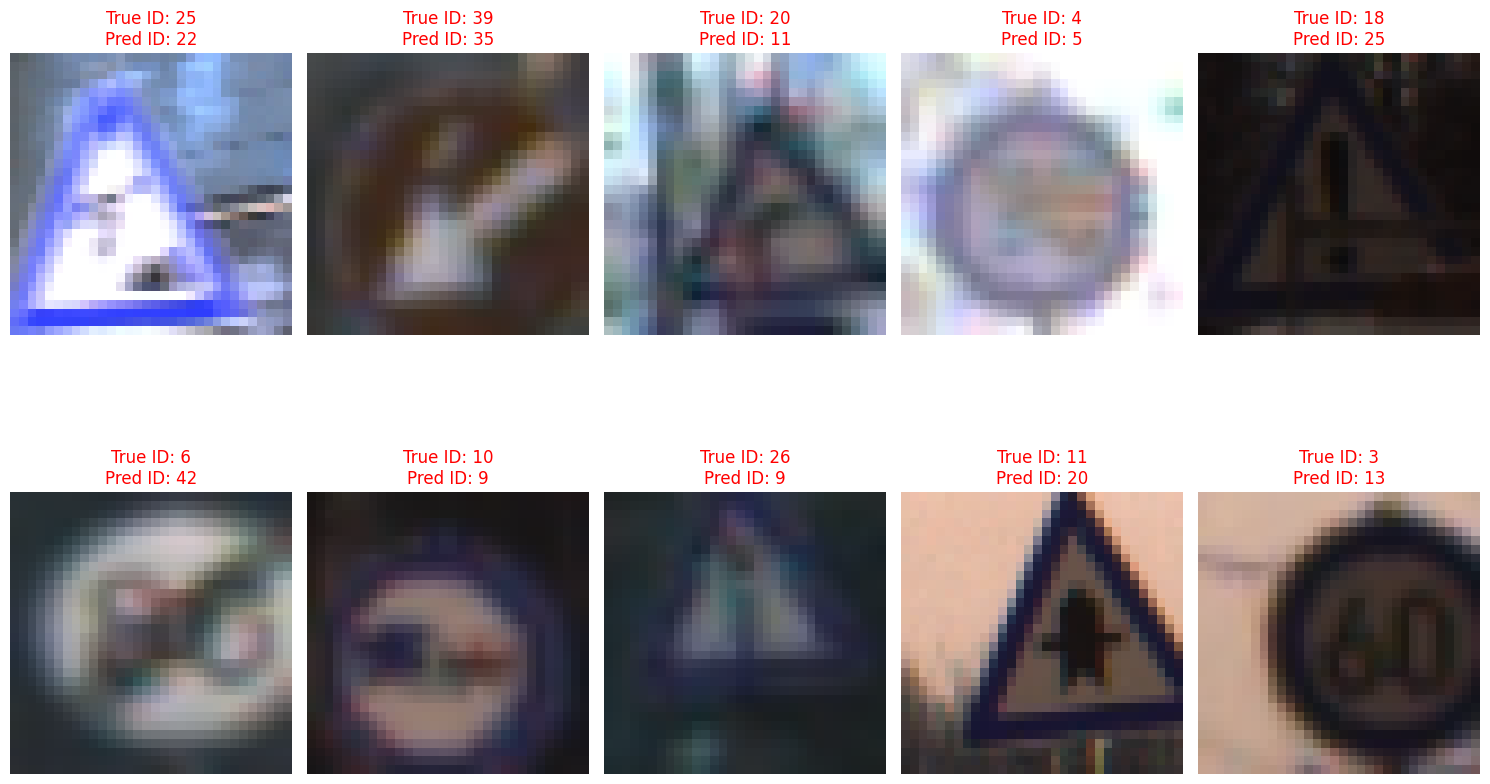

In [ ]:
# Falsch klassifizierte Bilder prüfen

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# # --- Modell laden ---

# # model_save_path = 'traffic_sign_classifier_model_32p.keras'
# model_save_path = 'traffic_sign_classifier_model_64p.keras'

# try:
#     model = tf.keras.models.load_model(model_save_path)
#     print(f"\nModell '{model_save_path}' erfolgreich geladen.")
# except Exception as e:
#     print(f"Fehler beim Laden des Modells: {e}. Stelle sicher, dass der Pfad korrekt ist.")
#     exit() 

# Vorhersagen auf dem Testset erhalten 
print("\nErstelle Vorhersagen für die Fehleranalyse...")
y_pred_probs = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) 

# Echte Labels des Testsets
y_true_classes = np.argmax(y_test_final, axis=1) 

# Finde falsch klassifizierte Bilder 
incorrect_predictions = y_pred_classes != y_true_classes
incorrect_indices = np.where(incorrect_predictions)[0]

print(f"Anzahl der falsch klassifizierten Bilder im Testset: {len(incorrect_indices)}")

# Visualisierung einiger falsch klassifizierter Bilder
if len(incorrect_indices) > 0:
    print("\nVisualisiere einige falsch klassifizierte Bilder:")
    plt.figure(figsize=(15, 10))
    num_display = min(len(incorrect_indices), 10) 

    for i in range(num_display):
        idx = incorrect_indices[i]
        
        image_display = X_test[idx] 
        
        true_label = y_true_classes[idx]
        predicted_label = y_pred_classes[idx]
        
        plt.subplot(2, 5, i + 1) 
        plt.imshow(image_display)
        plt.title(f"True ID: {true_label}\nPred ID: {predicted_label}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Keine Fehlklassifikationen gefunden. Dein Modell ist perfekt (oder das Testset zu klein)!")


Form des vorbereiteten Bildes für die Vorhersage: (1, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Vorhersage abgeschlossen.
Ausgewähltes Bild Index (aus X_test): 2174
Wahre Klasse (ID): 8
Vorhergesagte Klasse (ID): 8
Konfidenz der Vorhersage: 1.0000
Vorhersage ist korrekt: Ja


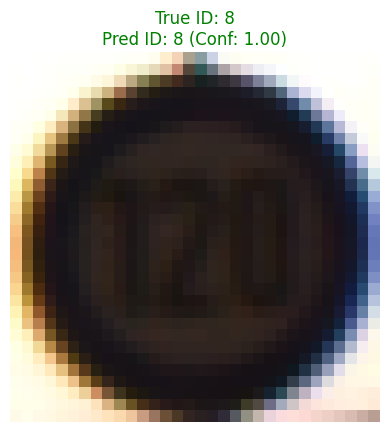

In [ ]:
# Korrekt klassifizierte Bilder prüfen

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# --- Modell laden ---
# model_path = 'traffic_sign_classifier_model.keras'
# try:
#     loaded_model = tf.keras.models.load_model(model_path)
#     print(f"Modell '{model_path}' erfolgreich geladen.")
# except Exception as e:
#     print(f"Fehler beim Laden des Modells: {e}. Stelle sicher, dass der Pfad korrekt ist.")
#     exit()

# --- Ein Bild aus dem TESTSET für die Vorhersage auswählen (X_test und y_test_final) ---


random_index = np.random.randint(0, len(X_test))

image_to_predict = X_test[random_index]
true_label_one_hot = y_test_final[random_index]

true_class_id = np.argmax(true_label_one_hot)

final_image_for_prediction = np.expand_dims(image_to_predict, axis=0)

print(f"\nForm des vorbereiteten Bildes für die Vorhersage: {final_image_for_prediction.shape}")

# Vorhersage treffen
predictions = loaded_model.predict(final_image_for_prediction)
predicted_class_id = np.argmax(predictions)
confidence = np.max(predictions)

# Ergebnisse anzeigen und vergleichen
print(f"\nVorhersage abgeschlossen.")
print(f"Ausgewähltes Bild Index (aus X_test): {random_index}")

print(f"Wahre Klasse (ID): {true_class_id}")
print(f"Vorhergesagte Klasse (ID): {predicted_class_id}")
print(f"Konfidenz der Vorhersage: {confidence:.4f}")

# Überprüfen, ob die Vorhersage korrekt war
is_correct = (predicted_class_id == true_class_id)
print(f"Vorhersage ist korrekt: {'Ja' if is_correct else 'Nein'}")

# Bild anzeigen mit Vorhersage und wahrem Label
plt.imshow(image_to_predict) 
title_color = 'green' if is_correct else 'red'
plt.title(f"True ID: {true_class_id}\nPred ID: {predicted_class_id} (Conf: {confidence:.2f})", color=title_color)
plt.axis('off')
plt.show()


Starte Robustheitsanalyse mit simulierten Bedingungen...

Beispielbilder mit angewandten Effekten:


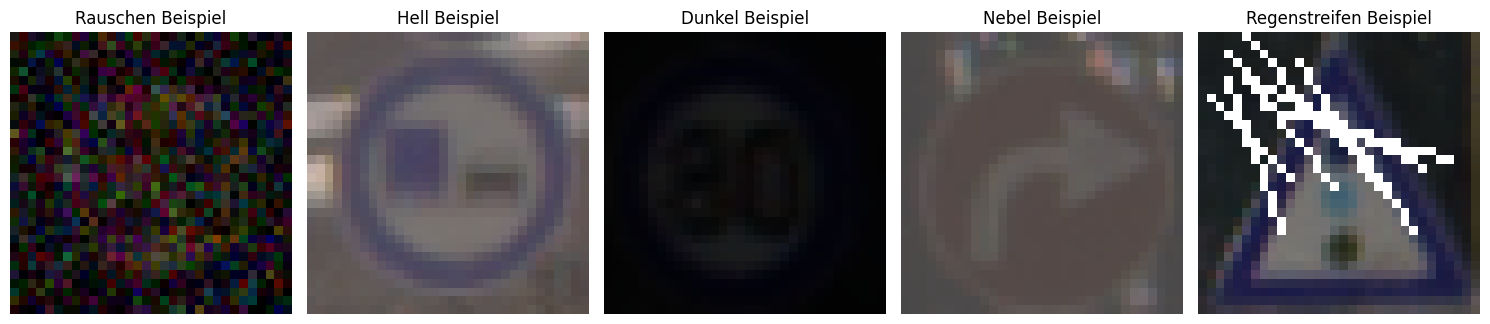


Bewerte Modell auf 'Original' Testset...
num_misclassified: 31
total_test_images: 7776
  Original - Test-Verlust: 0.0207, Test-Genauigkeit: 0.9961, Falsch klassifiziert: 31 von 7776 (0.40%)

Bewerte Modell auf 'Rauschen' Testset...
num_misclassified: 1015
total_test_images: 7776
  Rauschen - Test-Verlust: 0.4769, Test-Genauigkeit: 0.8695, Falsch klassifiziert: 1015 von 7776 (13.05%)

Bewerte Modell auf 'Hell' Testset...
num_misclassified: 126
total_test_images: 7776
  Hell - Test-Verlust: 0.0615, Test-Genauigkeit: 0.9838, Falsch klassifiziert: 126 von 7776 (1.62%)

Bewerte Modell auf 'Dunkel' Testset...
num_misclassified: 556
total_test_images: 7776
  Dunkel - Test-Verlust: 0.2964, Test-Genauigkeit: 0.9286, Falsch klassifiziert: 556 von 7776 (7.15%)

Bewerte Modell auf 'Nebel' Testset...
num_misclassified: 543
total_test_images: 7776
  Nebel - Test-Verlust: 0.3118, Test-Genauigkeit: 0.9303, Falsch klassifiziert: 543 von 7776 (6.98%)

Bewerte Modell auf 'Regenstreifen' Testset...
num_m

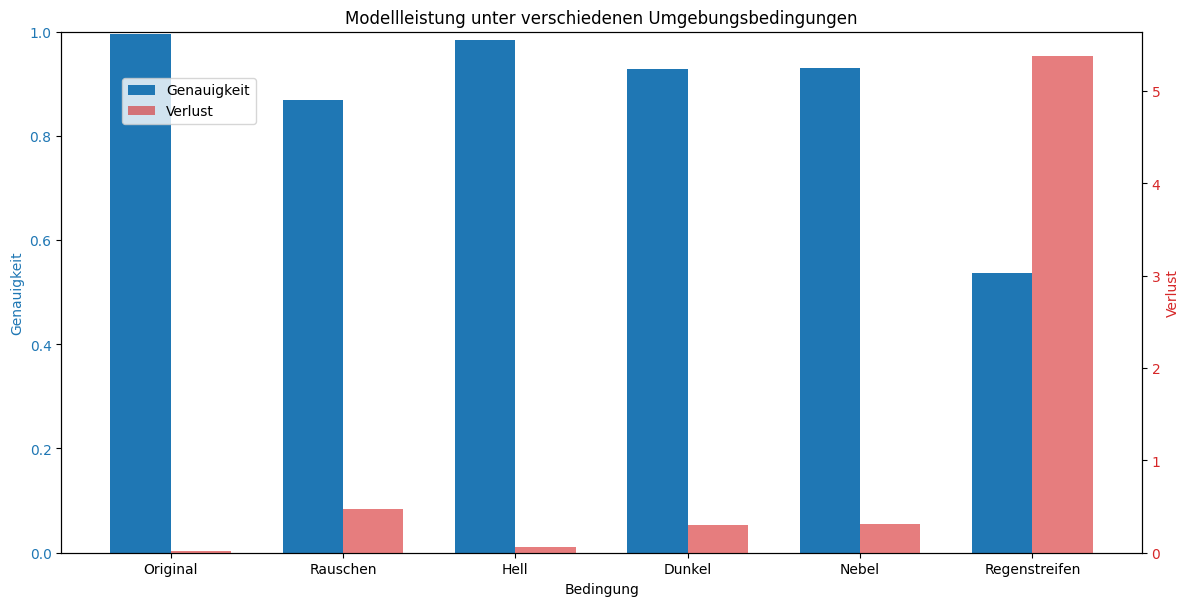

In [ ]:
#Robustheit des Models gegenüber random noise, brightness, fog and "rain" simuliert via skimage

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
from skimage.util import random_noise
from skimage import exposure
from skimage.color import rgb2gray, gray2rgb
import os

# --- Modell laden ---

# model_save_path = 'traffic_sign_classifier_model.keras'
# try:
#     model = tf.keras.models.load_model(model_save_path)
#     print(f"\nModell '{model_save_path}' erfolgreich geladen.")
# except Exception as e:
#     print(f"Fehler beim Laden des Modells: {e}.")
    
    # Reminder: `X_test`, `y_test_final` und `loaded_model` müssen aus vorherigen Schritten verfügbar sein

print(f"\nStarte Robustheitsanalyse mit simulierten Bedingungen...")


def add_random_noise(image_batch):
    noisy_batch = np.array([random_noise(img, mode='gaussian', var=0.01) for img in image_batch])
    return noisy_batch.astype(np.float32)

def adjust_brightness(image_batch, factor_range=(0.5, 1.5)):
    #gamma > 1: Bild dunkler
    #gamme < 1: Bild heller
    adjusted_batch = np.array([exposure.adjust_gamma(img, gamma=random.uniform(*factor_range)) for img in image_batch])
    return adjusted_batch.astype(np.float32)


def simulate_fog(image_batch, fog_intensity_range=(0.2, 0.6), fog_color=(0.8, 0.8, 0.8)):
    # Simuliert Nebel durch Mischen mit einer Grauwertfläche
    # image_batch sollte im Bereich [0, 1] sein
    foggy_batch = []
    for img in image_batch:
        fog_intensity = random.uniform(*fog_intensity_range)
        # Erstelle eine Nebelschicht mit der angegebenen Farbe
        fog_layer = np.ones_like(img) * np.array(fog_color).reshape(1, 1, -1) # Form (1,1,3) für Broadcasting
        
        # Lineare Interpolation zwischen Bild und Nebelschicht
        foggy_img = img * (1 - fog_intensity) + fog_layer * fog_intensity
        
        # Sicherstellen, dass Werte im Bereich [0, 1] bleiben
        foggy_img = np.clip(foggy_img, 0, 1)
        
        foggy_batch.append(foggy_img)
    return np.array(foggy_batch).astype(np.float32)

def simulate_rain_streaks(image_batch, num_streaks=5, streak_length=15):
    rainy_batch = []
    for img in image_batch:
        temp_img = img.copy()
        for _ in range(num_streaks):
            x = random.randint(0, img.shape[1] - streak_length)
            y = random.randint(0, img.shape[0] - streak_length)
            cv2.line(temp_img, (x, y), (x + random.randint(5, streak_length), y + random.randint(5, streak_length)), (1, 1, 1), 1)
        rainy_batch.append(temp_img)
    return np.array(rainy_batch).astype(np.float32)

# --- Bewertung auf modifizierten Testsets ---

test_conditions = {
    "Original": X_test,
    "Rauschen": add_random_noise(X_test),
    "Hell": adjust_brightness(X_test, factor_range=(0.2, 0.6)),
    "Dunkel": adjust_brightness(X_test, factor_range=(1.5, 2.5)),
    "Nebel": simulate_fog(X_test),
    "Regenstreifen": simulate_rain_streaks(X_test, num_streaks=random.randint(5,15), streak_length=random.randint(10,30))
}

results = {}
total_test_images = X_test.shape[0]

# Visualisiere ein Beispielbild pro Effekt
print("\nBeispielbilder mit angewandten Effekten:")
plt.figure(figsize=(15, 6))
plot_idx = 1
for name, data_batch in test_conditions.items():
    if name != "Original": 
        sample_img = data_batch[random.randint(0, len(data_batch) - 1)]
        plt.subplot(1, len(test_conditions) -1 , plot_idx)
        plt.imshow(sample_img)
        plt.title(f"{name} Beispiel")
        plt.axis('off')
        plot_idx += 1
plt.tight_layout()
plt.show()


# Modellbewertung für jede Bedingung
for condition_name, modified_X_test in test_conditions.items():
    print(f"\nBewerte Modell auf '{condition_name}' Testset...")
    loss, accuracy = loaded_model.evaluate(modified_X_test, y_test_final, verbose=0)
    num_misclassified = total_test_images - int(accuracy * total_test_images)
    missclassified_percent = (num_misclassified/total_test_images)*100
    print(f"num_misclassified: {num_misclassified}")
    print(f"total_test_images: {total_test_images}")
    results[condition_name] = {'loss': loss, 'accuracy': accuracy, 'misclassified': num_misclassified, 'misclassified_percentage': missclassified_percent}
    print(f"  {condition_name} - Test-Verlust: {loss:.4f}, Test-Genauigkeit: {accuracy:.4f}, Falsch klassifiziert: {num_misclassified} von {total_test_images} ({missclassified_percent:.2f}%)")

print("\n--- Zusammenfassung der Robustheitsanalyse ---")
for condition_name, metrics in results.items():
    print(f"{condition_name}: Genauigkeit = {metrics['accuracy']:.4f}, Verlust = {metrics['loss']:.4f}, Falsch klassifiziert = {metrics['misclassified']} von {total_test_images} ({missclassified_percent:.2f}%)")

# Diagramm der Ergebnisse
conditions = list(results.keys())
accuracies = [results[c]['accuracy'] for c in conditions]
losses = [results[c]['loss'] for c in conditions]

x = np.arange(len(conditions))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Bedingung')
ax1.set_ylabel('Genauigkeit', color=color)
ax1.bar(x - width/2, accuracies, width, label='Genauigkeit', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Verlust', color=color)
ax2.bar(x + width/2, losses, width, label='Verlust', color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Modellleistung unter verschiedenen Umgebungsbedingungen')
plt.xticks(x, conditions, rotation=45, ha="right")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# Schritt 7: Random Search (in Google Collab erledigt, aber hier der Vollständigkeit halber)

In [ ]:
!mkdir -p ~/.kaggle


from google.colab import files
files.upload()


!mv kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle kagglehub

import kagglehub
import os


dataset_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Lokaler Pfad zum GTSRB-Datensatz:", dataset_path)


print("\nInhalt des Datensatzordners:")
!ls -F {dataset_path}

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import os
import cv2
import pandas as pd
import numpy as np

def load_gtsrb_data(base_dataset_path):
    """
    Lädt den GTSRB-Datensatz aus dem angegebenen Kaggle-Verzeichnis.

    Args:
        base_dataset_path (str): Der absolute Pfad zum entpackten GTSRB-Datensatz,
                                 den kagglehub.dataset_download() zurückgibt.

    Returns:
        tuple: Ein Tupel, das zwei NumPy-Arrays enthält:
            - all_images (np.array): Ein Array aller geladenen Bilder (als NumPy-Arrays).
            - all_labels (np.array): Ein Array der entsprechenden Labels.
    """
    all_images = []
    all_labels = []

    # --- Trainingsdaten laden ---
    # In der Kaggle-Version ist die Haupt-CSV für Trainingsdaten 'Train.csv'
    train_csv_path = os.path.join(base_dataset_path, 'Train.csv')
    if not os.path.exists(train_csv_path):
        train_csv_path = os.path.join(base_dataset_path, 'Train', 'Train.csv')

    print(f"Versuche, Trainingsdaten zu laden von: {train_csv_path}")

    try:
        train_df = pd.read_csv(train_csv_path)
    except FileNotFoundError:
        print(f"Fehler: Trainings-CSV '{train_csv_path}' nicht gefunden. Kann keine Trainingsdaten laden.")
        return np.array([], dtype=object), np.array([])
    except Exception as e:
        print(f"Fehler beim Laden der Trainings-CSV '{train_csv_path}': {e}")
        return np.array([], dtype=object), np.array([])

    for index, row in train_df.iterrows():
        img_full_path = os.path.join(base_dataset_path, row['Path'])

        try:
            img = cv2.imread(img_full_path)
            if img is None:
                print(f"Warnung: Trainingsbild konnte nicht gelesen werden (img is None): {img_full_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


            x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
            cropped_img = img[y1:y2, x1:x2]

            all_images.append(cropped_img)
            all_labels.append(row['ClassId'])

        except Exception as e:
            print(f"Fehler beim Lesen oder Zuschneiden des Trainingsbildes '{img_full_path}': {e}")

    print(f"Erfolgreich {len(all_images)} Trainingsbilder geladen.")


    # --- Testdaten laden und an die gleichen Listen anhängen ---
    test_csv_path = os.path.join(base_dataset_path, 'Test.csv')
    if not os.path.exists(test_csv_path):
        test_csv_path = os.path.join(base_dataset_path, 'Test', 'Test.csv')

    print(f"Versuche, Testdaten zu laden von: {test_csv_path}")

    try:
        test_df = pd.read_csv(test_csv_path)
    except FileNotFoundError:
        print(f"Fehler: Test-CSV '{test_csv_path}' nicht gefunden. Testdaten werden nicht geladen.")
        return np.array(all_images, dtype=object), np.array(all_labels)
    except Exception as e:
        print(f"Fehler beim Laden der Test-CSV '{test_csv_path}': {e}")
        return np.array(all_images, dtype=object), np.array(all_labels)
    print(f"Spalten in Test-CSV: {test_df.columns.tolist()}")
    for index, row in test_df.iterrows():
        # Der Pfad in der CSV ist 'Filename', z.B. '00000.png'
        img_relative_path = row['Path']
        img_full_path = os.path.join(base_dataset_path, img_relative_path)
        # if index < 5:
        #     print(f"\nDEBUG-Test-Bild #{index}:")
        #     print(f"  base_dataset_path: {base_dataset_path}")
        #     print(f"  img_relative_path (aus CSV): {img_relative_path}")
        #     print(f"  Versuchter img_full_path: {img_full_path}")
        #     print(f"  Existiert der Ordner? {os.path.isdir(os.path.dirname(img_full_path))}")
        #     print(f"  Existiert die Datei? {os.path.exists(img_full_path)}")
        #     if os.path.isdir(os.path.dirname(img_full_path)):
        #         print(f"  Inhalt von {os.path.dirname(img_full_path)} (erste 5 Einträge):")
        #         try:
        #             files_in_dir = os.listdir(os.path.dirname(img_full_path))
        #             print(f"    {files_in_dir[:5]} ...")
        #         except Exception as ls_e:
        #             print(f"    Konnte Verzeichnis nicht listen: {ls_e}")
        #     else:
        #         print(f"  WARNUNG: Ordner {os.path.dirname(img_full_path)} existiert nicht!")

        try:
            img = cv2.imread(img_full_path)
            if img is None:
                print(f"Warnung: Testbild konnte nicht gelesen werden (img is None): {img_full_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


            x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
            cropped_img = img[y1:y2, x1:x2]

            all_images.append(cropped_img)
            all_labels.append(row['ClassId'])

        except Exception as e:
            print(f"Fehler beim Lesen oder Zuschneiden des Testbildes '{img_full_path}': {e}")

    print(f"Gesamt: {len(all_images)} Bilder und {len(all_labels)} Labels geladen.")

    return np.array(all_images, dtype=object), np.array(all_labels)

IMG_HEIGHT = 32
IMG_WIDTH = 32
num_classes = 43

print(f"Starte Ladevorgang aus: {dataset_path}")
images, labels = load_gtsrb_data(dataset_path)

print(f"\nErfolgreich {len(images)} Bilder und {len(labels)} Labels geladen.")

# Form des ersten Bildes überprüfen
if len(images) > 0:
    print(f"Form des ersten geladenen Bildes (nach ROI-Zuschnitt): {images[0].shape}")
    print(f"Label des ersten geladenen Bildes: {labels[0]}")
    print(f"Typ von 'images': {type(images)}, Typ der Elemente: {type(images[0])}")
    print(f"Typ von 'labels': {type(labels)}, Typ der Elemente: {type(labels[0])}")


# --- Skalierung auf einheitliche Größe, Farbkonvertierung und Normalisierung ---
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3 

processed_images = []
for img in images:
    #edge cases
    if len(img.shape) == 2: 
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 
    elif img.shape[2] == 4: 
        img_bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR) 
    else: 
        img_bgr = img

    resized_img = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))
    resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) 
    processed_images.append(resized_img_rgb)

X = np.array(processed_images) 


# Normalisierung der Pixelwerte auf [0, 1]
X = X / 255.0

print(f"Form des verarbeiteten und normalisierten Bild-Arrays (X): {X.shape}")
print(f"Minimale Pixelwert nach Normalisierung: {np.min(X)}")
print(f"Maximale Pixelwert nach Normalisierung: {np.max(X)}")


#Label-Kodierung One-Hot-Encoding

from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(labels))
y = to_categorical(labels, num_classes=num_classes)

print(f"Original Label des ersten Bildes: {labels[0]}")
print(f"One-Hot kodiertes Label des ersten Bildes: {y[0]}")
print(f"Form der kodierten Labels (y): {y.shape}")

from sklearn.model_selection import train_test_split

# finales Testset abtrennen
X_train_val, X_test, y_train_val, y_test, labels_train_val, labels_test = train_test_split(
    X, y, labels, test_size=0.15, random_state=42, stratify=labels
)

# Rest in Training und Validierung aufteilen
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=labels_train_val
)

print(f"\nDaten vorbereitet:")
print(f"Trainingsdaten: X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"Validierungsdaten: X_val.shape={X_val.shape}, y_val.shape={y_val.shape}")
print(f"Testdaten: X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
print(f"Anzahl der Klassen: {num_classes}")






import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt 

# Assuming:
# X_train_val, y_train_val, X_test, y_test
# IMG_HEIGHT, IMG_WIDTH, num_classes

# --- Install KerasTuner  ---

!pip install keras-tuner -q

# --- Model Funktion für Keras Tuner ---


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))) 

    # Hyperparameter: Anz. der Convolutional Layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)

    for i in range(num_conv_layers):
        # Hyperparameter: Anz Filter für jedes Conv. Layer
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_conv_{i}', min_value=0.0, max_value=0.3, step=0.1)))

    model.add(layers.Flatten())

    # Hyperparameter: Anz. der Dense Layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=2, step=1)

    for i in range(num_dense_layers):
        # Hyperparameter: Anz. der Units in jedem Dense Layer
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=128),
            activation='relu'
        ))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_dense_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Dense(num_classes, activation='softmax')) # Output layer

    # Hyperparameter: Learning rate für den Adam Optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Keras Tuner initialisieren
tuner = kt.RandomSearch(
    build_model,          
    objective='val_accuracy', 
    max_trials=20,        
    executions_per_trial=1, 
    directory='image_classifier',   
    project_name='gtsrb_tuning' 
)

# Callbacks (EarlyStopping) definieren

es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Suche starten
print("Starte KerasTuner Random Search...")
tuner.search(
    X_train_val, y_train_val,
    epochs=50, 
    validation_data=(X_test, y_test), 
    callbacks=[es_callback]
)
print("KerasTuner Random Search beendet.")

# Bestes Modell speichern
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"\nBeste Hyperparameter: {best_hps.values}")
best_model.summary()

# Model auf dem Testset evaluieren

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Genauigkeit des besten Modells auf dem Testset: {accuracy:.4f}")


ModuleNotFoundError: No module named 'scikeras'


### Sources

https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175

https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial

https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

https://datascientest.com/de/convolutional-neural-network-2



### Notizen


Was ich noch vergessen hatte zu erwähnen, als ich dann die Grafikkarte zig mal getauscht hatte (hab am Ende wieder die AMD reingetan) ging das Training plötzlich schneller. Vorher hat einmal Modeltraining etwa eine halbe Stunde gedauert, danach irgendwie nur noch so 7 Minuten, keine Ahnung warum, Technik ist manchmal seltsam :D. War aber erst recht zum Schluss, da hab ich dann nicht nochmal mit einer Grid Search begonnen. 

Die trainierten Models hab ich nicht mit hochgemaden, vor allem die Random Trees sind ziemlich groß, genauso wie die Rotdaten selber, die sind aber unter dem Link ganz oben zu finden. Dafür gibt es die datatree.txt, die quasi das Filesystem zeigt und einen Example Ausschnitt aus einer der csv Dateien zeigt.
Die Results hab ich auch nicht extra hochgeladen, da die alle in den slides sind. 